In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pymongo
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import os

In [2]:
client_mongo = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
db = client_mongo["off"]
products = db["products"]
classified_products = db["classified_products"]

In [3]:
data = list(classified_products.find())
df_classified_products = pd.DataFrame(data)
df_classified_products.head()

,_id,product_name,category,code_bar
0,66df51e157d2c9919ae94ebd,Hot Dog Relish,Condiments et sauces,0000013631062
1,66df51e157d2c9919ae94ebe,Chocolat,Produits sucrés,0000018568011
2,66df51e157d2c9919ae94ebf,Tripoux,Plats préparés,0000018927207
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127


In [4]:
categories = set(df_classified_products["category"])
print(len(categories), "categories found")
categories

16 categories found


{'Alcool',
 'Boissons',
 'Boissons sucrées',
 'Condiments et sauces',
 'Eau',
 'Fruits et légumes',
 'Féculents',
 'Féculents et légumes secs (légumineuses)',
 'Matières grasses',
 'Plats préparés',
 'Produits laitiers',
 'Produits sucrés',
 'Sel',
 'UNDEFINED',
 'Viande, poisson et fruits de mer',
 'Vitamines et minéraux'}

In [5]:
df_classified_products["ingredients"] = df_classified_products["code_bar"].apply(
    lambda x: products.find_one({"_id": x}).get("ingredients_text", "") if products.find_one({"_id": x}) else ""
)

In [6]:
df_classified_products = df_classified_products[
    (df_classified_products["product_name"] != "") & (df_classified_products["ingredients"] != "")
]
print(len(df_classified_products))
df_classified_products.head()

99009


,_id,product_name,category,code_bar,ingredients
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_."
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug..."
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl..."
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu..."
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th..."


In [7]:
import spacy

nlp_fr = spacy.blank('fr')
nlp_en = spacy.blank('en')
custom_stop_words = {
    'contient', 'ajouté', 'fabriqué', 'produit', 'avec', 'sans', 'dans', 'compris', 
    'préparé', 'utilisé', 'peut', 'contenir', 'ingrédients', 'et', 'ou', 'de', 'du', 
    'des', 'la', 'le', 'les', 'une', 'un', 'aux', 'à', 'pour', 'par', 'en', 'sur', 
    'au', 'avant', 'après', 'ce', 'cette', 'cet', 'ces', 'tout', 'tous', 'tout', 
    'sa', 'son', 'ses', 'leur', 'leurs', 'est', 'sont', 'été', 'sera', 'seront', 
    'a', 'ont', 'avait', 'fait', 'faire', 'incluant', 'inclut', 'comme', 'également', 
    'autres', 'autre', 'plus', 'moins', 'très', 'bien', 'mal', 'quantité', 'mélange', 
    'concentré', 'issu', 'issus', 'à base de', 'teneur', 'préparé', 'extrait', 'origine', 
    'composants', 'selon', 'réduit', 'haute', 'basse', 'qualité', 'frais', 'séché', 
    'congelé', 'emballé', 'transformé', 'réfrigéré', 'd’origine', 'de haute', 'de basse',
    'contenu', 'naturel', 'synthétique', 'additionné', 'modifié', 'dérivé', 'processus', 
    'procédé', 'avec', 'sans', 'naturellement', 'élaboré', 'utilisation', 'fabrication',
    'employé', 'fabriqué', 'obtenu', 'déshydraté', 'portion', 'portionné', 'mélangé', 
    'préparation', 'composition', 'complémentaire', 'provenant', 'extrait', 'adapté', "_sulfites_",
    'divers', 'façon', 'type', 'mode', 'conditionné', 'issu de', 'fabriqué dans', 'mis en'
}

stop_words_fr = nlp_fr.Defaults.stop_words
stop_words_en = nlp_en.Defaults.stop_words

stop_words = stop_words_fr.union(stop_words_en).union(custom_stop_words)

print(list(stop_words)[:10])

['faisaient', 'c’', 'differente', 'doit', 'neuvième', 'sait', 'siennes', 'somewhere', 'anyone', 'except']


In [8]:
def tokenize_and_remove_stopwords(text: str) -> list:
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = text.lower().split()
    
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return filtered_tokens

tensor_df = df_classified_products.copy()

tensor_df["product_name_tokens"] = tensor_df["product_name"].apply(tokenize_and_remove_stopwords)
tensor_df["ingredients_tokens"] = tensor_df["ingredients"].apply(tokenize_and_remove_stopwords)
tensor_df.head()

,_id,product_name,category,code_bar,ingredients,product_name_tokens,ingredients_tokens
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_.","[côtes, rhône, villages, 2014]","[vin, rouge, sec]"
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug...","[butter, croissants]","[wheat, flour, butter, cream, water, yeast, su..."
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl...","[wild, blueberry, muffins]","[enriched, wheat, flour, wheat, flour, malted,..."
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu...",[bolillos],"[enriched, wheat, flour, wheat, flour, niacin,..."
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th...",[biscuit],"[enriched, wheat, flour, niacin, reduced, iron..."


       product_name_len  ingredients_len
count      99009.000000     99009.000000
mean           4.029543        30.913604
std            2.049151        29.647230
min            0.000000         0.000000
25%            3.000000        11.000000
50%            4.000000        23.000000
75%            5.000000        40.000000
max           94.000000       407.000000


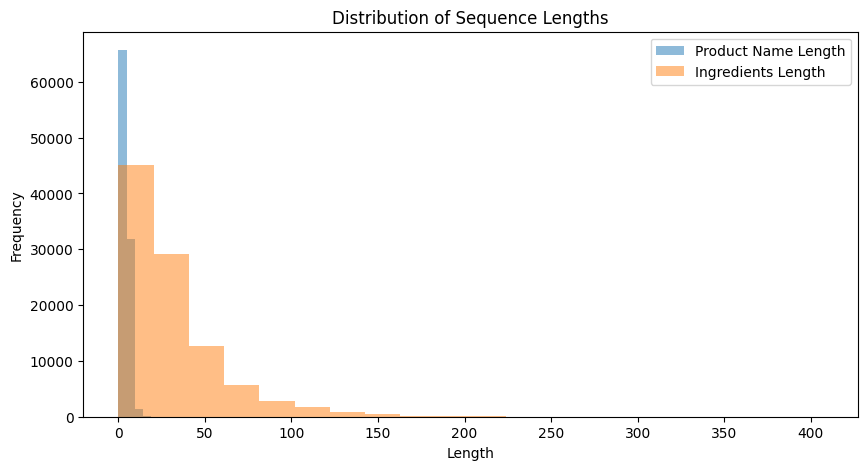

In [9]:
# Calculer la longueur des séquences de tokens pour les noms de produits et ingrédients
tensor_df['product_name_len'] = tensor_df['product_name_tokens'].apply(len)
tensor_df['ingredients_len'] = tensor_df['ingredients_tokens'].apply(len)

# Afficher des statistiques sur les longueurs
print(tensor_df[['product_name_len', 'ingredients_len']].describe())

# Visualiser la distribution des longueurs
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(tensor_df['product_name_len'], bins=20, alpha=0.5, label='Product Name Length')
plt.hist(tensor_df['ingredients_len'], bins=20, alpha=0.5, label='Ingredients Length')
plt.legend(loc='upper right')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [10]:
all_tokens = set(token for tokens in tensor_df['product_name_tokens'] for token in tokens)
all_tokens.update(token for tokens in tensor_df['ingredients_tokens'] for token in tokens)

In [11]:
from typing import Any


vocab = {token: idx for idx, token in enumerate(all_tokens, start=1)}  # Padding index = 0
VOCAB_SIZE = len(vocab) + 1  # Ajout du padding (index 0)

def tokens_to_indices(tokens, vocab: dict, max_length: int):
    # Ne prendre que les tokens qui existent dans le vocabulaire
    indices = [vocab[token] for token in tokens if token in vocab]
    if len(indices) > max_length:
        return indices[:max_length]
    else:
        return indices + [0] * (max_length - len(indices))


MAX_LEN_PRODUCT_NAME = 7
MAX_LEN_INGREDIENTS = 60

tensor_df['product_name_indices'] = tensor_df['product_name_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_PRODUCT_NAME))
tensor_df['ingredients_indices'] = tensor_df['ingredients_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_INGREDIENTS))

print(f"Vocab Size: {VOCAB_SIZE}")


Vocab Size: 32169


In [12]:
# Vérification que tous les indices sont dans les limites du vocabulaire
def verify_indices_within_vocab(indices, vocab_size):
    invalid_indices = [idx for idx in indices if not (0 <= idx < vocab_size)]
    if invalid_indices:
        raise ValueError(f"Des indices en dehors du vocabulaire trouvés : {invalid_indices}")

# Appliquer la vérification sur les colonnes de données
tensor_df['product_name_indices'].apply(lambda x: verify_indices_within_vocab(x, VOCAB_SIZE))
tensor_df['ingredients_indices'].apply(lambda x: verify_indices_within_vocab(x, VOCAB_SIZE))

label_encoder = LabelEncoder()
import json
tensor_df["category_idx"] = label_encoder.fit_transform(tensor_df["category"])
category_to_index = {category: index for category, index in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

# Étape 3 : Sauvegarder le mapping en format JSON
with open('category_to_index.json', 'w') as json_file:
    json.dump(category_to_index, json_file, indent=4)
print(f"Vocab Size: {VOCAB_SIZE}")
print("Tous les indices sont bien dans les limites du vocabulaire.")
tensor_df.head()

Vocab Size: 32169
Tous les indices sont bien dans les limites du vocabulaire.


,_id,product_name,category,code_bar,ingredients,product_name_tokens,ingredients_tokens,product_name_len,ingredients_len,product_name_indices,ingredients_indices,category_idx
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_.","[côtes, rhône, villages, 2014]","[vin, rouge, sec]",4,3,"[4582, 10526, 8844, 12951, 0, 0, 0]","[21366, 14242, 24072, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug...","[butter, croissants]","[wheat, flour, butter, cream, water, yeast, su...",2,14,"[22337, 2358, 0, 0, 0, 0, 0]","[19392, 24905, 22337, 22730, 227, 20738, 12013...",9
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl...","[wild, blueberry, muffins]","[enriched, wheat, flour, wheat, flour, malted,...",3,34,"[1447, 15469, 3134, 0, 0, 0, 0]","[2741, 19392, 24905, 19392, 24905, 1783, 10855...",9
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu...",[bolillos],"[enriched, wheat, flour, wheat, flour, niacin,...",1,34,"[23940, 0, 0, 0, 0, 0, 0]","[2741, 19392, 24905, 19392, 24905, 18305, 1103...",6
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th...",[biscuit],"[enriched, wheat, flour, niacin, reduced, iron...",1,33,"[29727, 0, 0, 0, 0, 0, 0]","[2741, 19392, 24905, 18305, 1103, 362, 17412, ...",9


In [13]:
tensor_df = tensor_df[['product_name_indices', 'ingredients_indices', 'category_idx']]
X = tensor_df[['product_name_indices', 'ingredients_indices']]
y = tensor_df['category_idx']
tensor_df.to_csv('tensor_data.csv', index=False)
pd.read_csv('tensor_data.csv').head()

print(len(tensor_df))
tensor_df = tensor_df.dropna()
# check if a list is empty
tensor_df = tensor_df[tensor_df.astype(str)['product_name_indices'] != '[]']
tensor_df = tensor_df[tensor_df.astype(str)['ingredients_indices'] != '[]']
tensor_df = tensor_df[tensor_df.astype(str)['category_idx'] != '']
print(len(tensor_df))

tensor_df.head()

99009
99009


,product_name_indices,ingredients_indices,category_idx
3,"[4582, 10526, 8844, 12951, 0, 0, 0]","[21366, 14242, 24072, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[22337, 2358, 0, 0, 0, 0, 0]","[19392, 24905, 22337, 22730, 227, 20738, 12013...",9
5,"[1447, 15469, 3134, 0, 0, 0, 0]","[2741, 19392, 24905, 19392, 24905, 1783, 10855...",9
6,"[23940, 0, 0, 0, 0, 0, 0]","[2741, 19392, 24905, 19392, 24905, 18305, 1103...",6
7,"[29727, 0, 0, 0, 0, 0, 0]","[2741, 19392, 24905, 18305, 1103, 362, 17412, ...",9


In [14]:
#show table that count the number of produit in each category
tensor_df.groupby("category_idx").count()

,product_name_indices,ingredients_indices
category_idx,,
0,72,72
1,3048,3048
2,5725,5725
3,13019,13019
4,354,354
5,3791,3791
6,9298,9298
7,5321,5321
8,1745,1745


In [15]:
from ProductClassifierLSTM import ProductClassifierLSTM

In [16]:
EMBEDDING_DIM = 128  # Dimension des embeddings
HIDDEN_DIM = 256  # Dimension des sorties cachées des LSTM
NUM_CLASSES = len(categories)  # Nombre de catégories de produits (16)
MAX_LEN_PRODUCT_NAME = MAX_LEN_PRODUCT_NAME  # Longueur maximale pour les noms de produits
MAX_LEN_INGREDIENTS = MAX_LEN_INGREDIENTS  # Longueur maximale pour les ingrédients

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Fonction pour filtrer les lignes avec des indices hors limites
def filter_out_of_vocab_rows(X, y, vocab_size):
    valid_rows = []
    for idx, row in X.iterrows():
        if all(0 <= idx < vocab_size for idx in row['product_name_indices']) and \
           all(0 <= idx < vocab_size for idx in row['ingredients_indices']):
            valid_rows.append((row, y[idx]))
    return zip(*valid_rows) if valid_rows else (pd.DataFrame(), pd.Series())

# Filtrer les lignes hors limites
X_filtered, y_filtered = filter_out_of_vocab_rows(X, y, VOCAB_SIZE)

# Diviser les données en train et test après avoir filtré
train_X, test_X, train_y, test_y = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


In [18]:
from sklearn.model_selection import train_test_split
from ProductDataset import ProductDataset
from torch.utils.data import DataLoader

# Diviser les données en train et test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
# Créer les datasets et dataloaders pour l'entraînement et le test
train_dataset = ProductDataset(train_X, train_y, VOCAB_SIZE)
test_dataset = ProductDataset(test_X, test_y, VOCAB_SIZE)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

def train_model(model, train_dataloader, criterion, optimizer, num_epochs=5, save_dir='./models'):
    # Créer le dossier de sauvegarde s'il n'existe pas
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    model.train()  # Mode entraînement
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(train_dataloader):
            # Récupérer les données du batch
            product_name = batch['product_name'].to(device)
            ingredients = batch['ingredients'].to(device)
            labels = batch['label'].to(device)

            # Vérifiez que les indices pour product_name et ingredients sont dans les limites du vocabulaire
            assert product_name.max() < VOCAB_SIZE, f"Indice product_name dépasse vocab_size ({VOCAB_SIZE})"
            assert ingredients.max() < VOCAB_SIZE, f"Indice ingredients dépasse vocab_size ({VOCAB_SIZE})"
            assert product_name.min() >= 0, "Indice product_name est négatif"
            assert ingredients.min() >= 0, "Indice ingredients est négatif"

            # Forward pass
            outputs = model(product_name, ingredients)
            loss = criterion(outputs, labels)
            
            # Backward pass et optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            print(f"\rEpoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}", end="")
        
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        # Sauvegarder le modèle à la fin de l'époque
        model_save_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")


Using device: cuda


In [20]:
EMBEDDING_DIM = 128  # Dimension des embeddings
HIDDEN_DIM = 256  # Dimension des sorties cachées des LSTM
NUM_CLASSES = len(categories)  # Nombre de catégories de produits (16)
MAX_LEN_PRODUCT_NAME = MAX_LEN_PRODUCT_NAME  # Longueur maximale pour les noms de produits
MAX_LEN_INGREDIENTS = MAX_LEN_INGREDIENTS  # Longueur maximale pour les ingrédients

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [21]:
model = ProductClassifierLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training on " + str(device))
train_model(model, train_dataloader, criterion, optimizer, num_epochs=16)

Training on cuda
Epoch [1/16], Step [2476/2476], Loss: 0.5971Epoch [1/16], Loss: 0.7111
Model saved to ./models\model_epoch_1.pth
Epoch [2/16], Step [2476/2476], Loss: 1.3362Epoch [2/16], Loss: 0.3936
Model saved to ./models\model_epoch_2.pth
Epoch [3/16], Step [2476/2476], Loss: 0.2942Epoch [3/16], Loss: 0.2922
Model saved to ./models\model_epoch_3.pth
Epoch [4/16], Step [2476/2476], Loss: 0.8661Epoch [4/16], Loss: 0.2248
Model saved to ./models\model_epoch_4.pth
Epoch [5/16], Step [2476/2476], Loss: 0.0112Epoch [5/16], Loss: 0.1714
Model saved to ./models\model_epoch_5.pth
Epoch [6/16], Step [2476/2476], Loss: 0.0621Epoch [6/16], Loss: 0.1371
Model saved to ./models\model_epoch_6.pth
Epoch [7/16], Step [2476/2476], Loss: 0.0803Epoch [7/16], Loss: 0.1113
Model saved to ./models\model_epoch_7.pth
Epoch [8/16], Step [2476/2476], Loss: 0.0684Epoch [8/16], Loss: 0.0933
Model saved to ./models\model_epoch_8.pth
Epoch [9/16], Step [2476/2476], Loss: 0.0296Epoch [9/16], Loss: 0.0811
Model sa

In [22]:
torch.save(model.state_dict(), 'model.pth')

In [23]:
# # load model.pth
# model = ProductClassifierLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# model.load_state_dict(torch.load('./models/model_epoch_18.pth'))
# model.eval()

In [24]:
def test_model(model, test_dataloader, criterion):
    model.eval()  # Passer le modèle en mode évaluation
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Listes pour stocker toutes les étiquettes et les prédictions
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Désactiver le calcul du gradient pour économiser de la mémoire et accélérer
        for batch in test_dataloader:
            product_name = batch['product_name'].to(device)
            ingredients = batch['ingredients'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(product_name, ingredients)
            
            # Calcul de la perte
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calcul des prédictions correctes
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            # Stocker les étiquettes et les prédictions pour un traitement ultérieur
            all_labels.extend(labels.cpu().numpy())  # Convertir en numpy et ajouter à la liste
            all_preds.extend(predicted.cpu().numpy())  # Convertir en numpy et ajouter à la liste

    avg_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")
    
    # Retourner l'historique : perte moyenne, précision, toutes les étiquettes et prédictions
    return avg_loss, accuracy, all_labels, all_preds


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model = model.to(device)
avg_loss, accuracy, all_labels, all_preds = test_model(model, test_dataloader, criterion)

Test Loss: 0.6747, Test Accuracy: 86.28%


In [26]:
model_dir = './models'
# Charger et évaluer chaque modèle dans le dossier models
def load_and_evaluate_models(model_class, dataloader, criterion):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    
    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        
        # Initialiser un nouveau modèle (tu dois passer la classe de ton modèle ici)
        model = model_class(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS).to(device)
        
        # Charger les poids du modèle
        model.load_state_dict(torch.load(model_path))
        
        # Évaluer le modèle
        avg_loss, accuracy = test_model(model, dataloader, criterion)
        
        print(f"Model {model_file}: Avg Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

# Exemple d'utilisation avec ton modèle, dataloader et criterion
# Assurez-vous que la classe `YourModelClass` est définie
load_and_evaluate_models(ProductClassifierLSTM, test_dataloader, criterion)

C:\Users\Azz\AppData\Local\Temp\ipykernel_8740\962048477.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.4820, Test Accuracy: 82.82%


ValueError: too many values to unpack (expected 2)

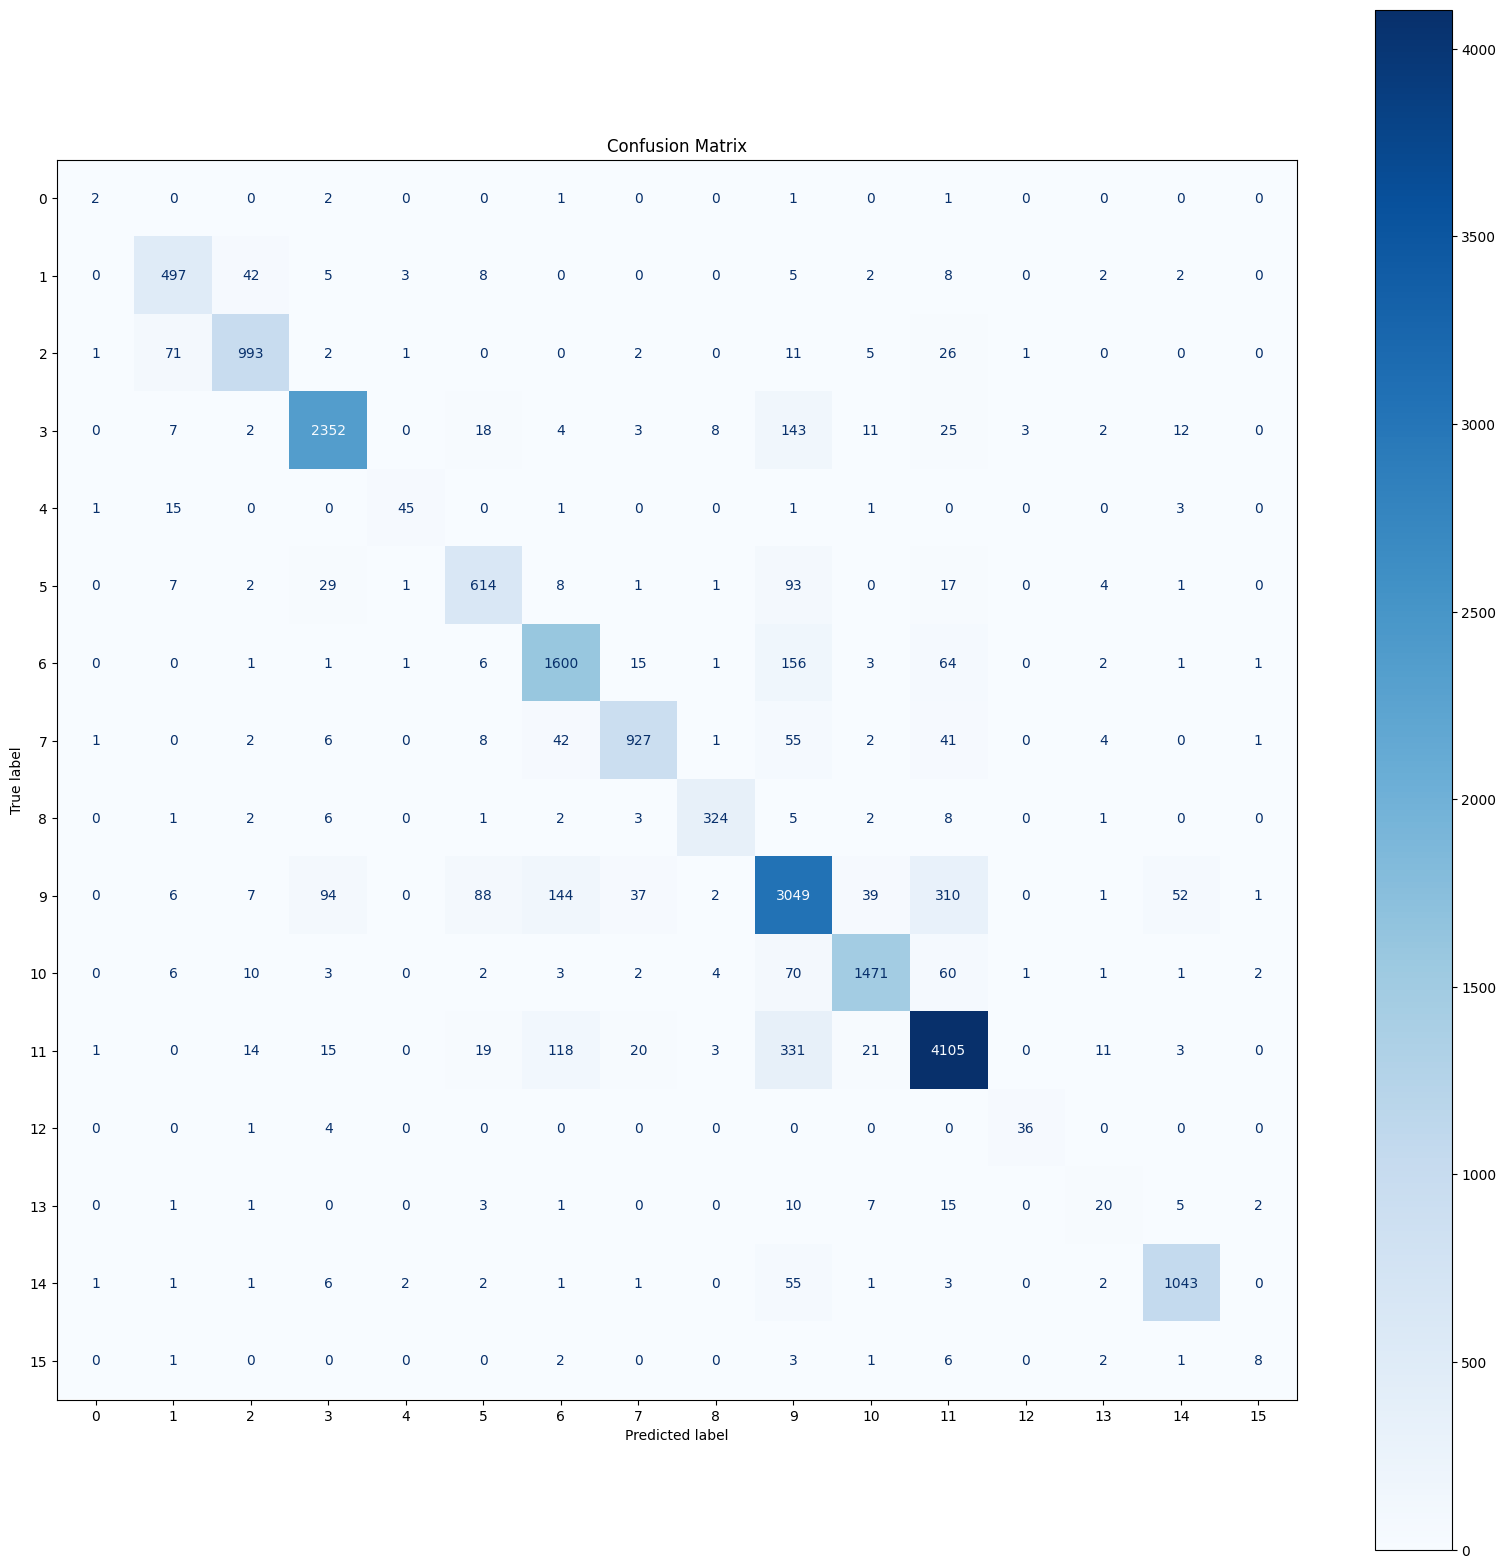

In [27]:
# Afficher la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))

# Agrandir la figure
fig, ax = plt.subplots(figsize=(20, 20))  # Ajuste ici la taille selon tes besoins (largeur, hauteur)
disp.plot(cmap=plt.cm.Blues, ax=ax)  # Utilise ax pour que la taille soit prise en compte

plt.title("Confusion Matrix")
plt.show()


In [28]:
# Définir la taille des chunks
from datetime import datetime, timedelta


one_year_ago_timestamp = int((datetime.now() - timedelta(days=365)).timestamp())
# Compter le nombre total de produits dans la collection
total_products = products.count_documents({
    "$and": [
        {"product_name": {"$ne": ""}},  # Exclure les produits sans nom
        {"ingredients_text": {"$ne": ""}},  # Exclure les produits sans ingrédients
        {"$or": [
            {"last_updated_t": {"$exists": False}},  # Inclure si la clé n'existe pas
            {"last_updated_t": {"$gte": one_year_ago_timestamp}}  # Ou inclure si mis à jour il y a moins d'un an
        ]}
    ]
})
print(f"Total de produits à traiter : {total_products}")



Total de produits à traiter : 3058854


In [31]:
from ProductDataset import ProductDataset

def prepare_tokens(df_products: pd.DataFrame) -> pd.DataFrame:
    df_products = df_products.dropna(subset=['product_name'])
    df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
    
    df_products["product_name_tokens"] = df_products["product_name"].apply(tokenize_and_remove_stopwords)
    df_products["ingredients_tokens"] = df_products["ingredients_text"].apply(tokenize_and_remove_stopwords)
    df_products = df_products[df_products['ingredients_tokens'].apply(lambda x: len(x) >= 1)]
    return df_products

# tokenisation des produits
def tranform_to_tensor(df_products: pd.DataFrame) -> pd.DataFrame:
    df_products['product_name_indices'] = df_products['product_name_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_PRODUCT_NAME))
    df_products['ingredients_indices'] = df_products['ingredients_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_INGREDIENTS))
    return df_products

last_id = "99999995"
CHUNK_SIZE = 100000
def create_tensor_dataset(df_products: pd.DataFrame, vocab_size: int) -> DataLoader:
    df_products['category_idx'] = 0
    dataset = ProductDataset(
        X=df_products,
        y=df_products['category_idx'], 
        VOCAB_SIZE=vocab_size
    )
    prediction_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    return prediction_dataloader

with open('data/category_to_index.json', 'r', encoding='utf-8') as json_file:
    category_mapping = json.load(json_file)
    
category_mapping = {v: k for k, v in category_mapping.items()}


def create_tensor_dataset(df_products: pd.DataFrame, vocab_size: int) -> DataLoader:
    df_products['category_idx'] = 0
    dataset = ProductDataset(
        X=df_products,
        y=df_products['category_idx'], 
        VOCAB_SIZE=vocab_size
    )
    prediction_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    return prediction_dataloader


pred_collection = db["predicted_categories"]

all_results = []
total_len = 0
for _ in range(0, total_products, CHUNK_SIZE):
    query = {
        "$and": [
            {"product_name": {"$ne": ""}},
            {"ingredients_text": {"$ne": ""}},
            {"$or": [
                {"last_updated_t": {"$exists": False}},
                {"last_updated_t": {"$gte": one_year_ago_timestamp}}
            ]}
        ]
    }

    if last_id:
        query["_id"] = {"$gt": last_id}
    
    product_chunk = products.find(query, {"product_name": 1, "ingredients_text": 1, '_id': 1}).limit(CHUNK_SIZE)
    
    data__ = pd.DataFrame(list(product_chunk))
    if data__.empty:
        print("No more products to process")
        break
    # check if have columns product_name and ingredients_text
    if 'product_name' not in data__.columns or 'ingredients_text' not in data__.columns:
        print("No product_name or ingredients_text columns found")
        # get last object id
        last_id = data__['_id'].iloc[-1]
        continue
    df_products = prepare_tokens(data__)
    df_products = tranform_to_tensor(df_products)
    prediction_dataloader = create_tensor_dataset(df_products, VOCAB_SIZE)
    predictions = []
    product_ids = df_products['_id'].tolist()  # Récupérer les _id des produits
    product_names = df_products['product_name'].tolist()  # Récupérer les noms de produits

    with torch.no_grad():
        for batch in prediction_dataloader:
            product_name_indices = batch['product_name'].to(device)
            ingredients_indices = batch['ingredients'].to(device)

            # Faire des prédictions avec le modèle
            outputs = model(product_name_indices, ingredients_indices)

            # Extraire les prédictions (classe avec la probabilité la plus élevée)
            _, predicted = torch.max(outputs, 1)

            # Convertir les prédictions en numpy et ajouter à la liste
            predictions.extend(predicted.cpu().numpy())

    # Transformer les indices des catégories en noms de catégories
    predicted_categories = [category_mapping[pred] for pred in predictions]

    # Stocker les résultats dans une liste
    for _id, name, category in zip(product_ids, product_names, predicted_categories):
        all_results.append({
            'codebar': _id,
            'product_name': name,
            'predicted_category': category
        })
    total_len += len(df_products)
    if all_results:
        pred_collection.insert_many(all_results)
        all_results.clear()
    last_id = product_ids[-1]
    print(f"\rProcessed {total_len}/{total_products} products", end="")

No product_name or ingredients_text columns found
No more products to process
